<a href="https://colab.research.google.com/github/aliahalotaibi73/week5_exercises/blob/main/RNN_Exercise.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **RNN Introduction**


## Importing required libraries


In [1]:
!pip install mplfinance
!pip install opendatasets

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 75.0/75.0 kB 2.3 MB/s eta 0:00:00


In [2]:
# Basic libraries
import numpy as np
import pandas as pd
import warnings
warnings.filterwarnings("ignore")

# For processing
import math
import random
import datetime as dt
import matplotlib.dates as mdates

# For visualization
import matplotlib.pyplot as plt
from mplfinance.original_flavor import candlestick_ohlc

# Libraries for model training
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import SimpleRNN, Dense, Dropout
from keras.callbacks import ModelCheckpoint, EarlyStopping
from sklearn.metrics import mean_squared_error

## Loading and preprocessing the data
### Dataset 4-Deep learning/5-Time Series Forecasting (RNN)/LAB/ٌDatasets/traffic.csv

In [3]:
df = pd.read_csv('/content/traffic.csv')
df.head()

,DateTime,Junction,Vehicles,ID
0,2015-11-01 00:00:00,1,15,20151101001
1,2015-11-01 01:00:00,1,13,20151101011
2,2015-11-01 02:00:00,1,10,20151101021
3,2015-11-01 03:00:00,1,7,20151101031
4,2015-11-01 04:00:00,1,9,20151101041


In [10]:
start_date=dt.datetime(2016,1,1)
end_date=dt.datetime(2017,1,1)

In [11]:
df['DateTime'] = pd.to_datetime(df['DateTime'])

In [12]:
# Filter the DataFrame based on the date range
df = df[(df['DateTime'] >= start_date) & (df['DateTime'] <= end_date)]

In [13]:
df.head()

,DateTime,Junction,Vehicles,ID
1464,2016-01-01 00:00:00,1,13,20160101001
1465,2016-01-01 01:00:00,1,13,20160101011
1466,2016-01-01 02:00:00,1,11,20160101021
1467,2016-01-01 03:00:00,1,6,20160101031
1468,2016-01-01 04:00:00,1,8,20160101041


In [14]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 26356 entries, 1464 to 43776
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype         
---  ------    --------------  -----         
 0   DateTime  26356 non-null  datetime64[ns]
 1   Junction  26356 non-null  int64         
 2   Vehicles  26356 non-null  int64         
 3   ID        26356 non-null  int64         
dtypes: datetime64[ns](1), int64(3)
memory usage: 1.0 MB


## Visualization

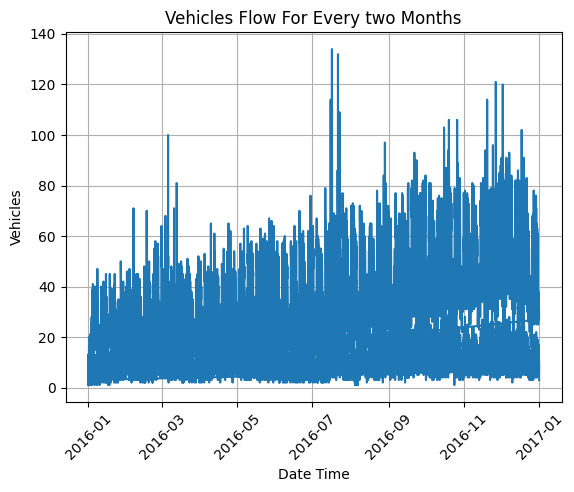

In [16]:
# Visualization For Temperature Flow For Every Four Months
plt.plot(df['DateTime'], df['Vehicles'])
plt.xlabel('Date Time')
plt.ylabel('Vehicles')
plt.title('Vehicles Flow For Every two Months')
plt.grid(True)
plt.xticks(rotation=45)
plt.show()

## Split the data into train and test

In [17]:
train_size = int(len(df) * 0.8)
train_data = df.iloc[:train_size]
test_data = df.iloc[train_size:]

In [18]:
# Select only numeric columns from your DataFrame before scaling
numeric_columns = df.select_dtypes(include=[np.number]).columns

train_data = df.iloc[:train_size][numeric_columns]
test_data = df.iloc[train_size:][numeric_columns]

In [19]:
scaler = MinMaxScaler(feature_range=(0, 1))
train_data_scaled = scaler.fit_transform(train_data)
test_data_scaled = scaler.transform(test_data)

In [20]:
# Prepare the data
def create_dataset(dataset, time_step):
    X, Y = [], []
    for i in range(len(dataset) - time_step - 1):
        a = dataset[i:(i + time_step), 0:dataset.shape[1]]
        X.append(a)
        Y.append(dataset[i + time_step, 0])
    return np.array(X), np.array(Y)

In [21]:
X_train, Y_train = create_dataset(train_data_scaled, 12)
X_test, Y_test = create_dataset(test_data_scaled, 12)

In [22]:
X_train.shape , Y_train.shape , X_test.shape , Y_test.shape

((21071, 12, 3), (21071,), (5259, 12, 3), (5259,))

In [23]:
# Reshape the data for LSTM input
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], train_data_scaled.shape[1])
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], test_data_scaled.shape[1])

## Modeling


In [25]:
modelRNN = Sequential()

modelRNN.add(SimpleRNN(units=50, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])))
modelRNN.add(Dropout(0.2))
modelRNN.add(SimpleRNN(units=50, return_sequences=True))
modelRNN.add(Dropout(0.2))
modelRNN.add(SimpleRNN(units=50, return_sequences=False))
modelRNN.add(Dropout(0.2))
modelRNN.add(Dense(units=1))
modelRNN.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ simple_rnn (SimpleRNN)               │ (None, 12, 50)              │           2,700 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 12, 50)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ simple_rnn_1 (SimpleRNN)             │ (None, 12, 50)              │           5,050 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 12, 50)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ simple_rnn_2 (SimpleRNN)             │ (None, 50)                  │           5,050 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 50)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 1)                   │              51 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 12,851 (50.20 KB)

 Trainable params: 12,851 (50.20 KB)

 Non-trainable params: 0 (0.00 B)

In [26]:
modelRNN.compile(loss='mean_squared_error',optimizer='adam')

In [27]:
modelRNN.fit(X_train, Y_train, validation_data=(X_test, Y_test), epochs=15, batch_size=64, verbose=1)

Epoch 1/15
330/330 ━━━━━━━━━━━━━━━━━━━━ 12s 23ms/step - loss: 0.1313 - val_loss: 0.0102
Epoch 2/15
330/330 ━━━━━━━━━━━━━━━━━━━━ 11s 25ms/step - loss: 0.0135 - val_loss: 4.2435e-04
Epoch 3/15
330/330 ━━━━━━━━━━━━━━━━━━━━ 10s 25ms/step - loss: 0.0069 - val_loss: 9.7196e-04
Epoch 4/15
330/330 ━━━━━━━━━━━━━━━━━━━━ 9s 20ms/step - loss: 0.0048 - val_loss: 9.1508e-04
Epoch 5/15
330/330 ━━━━━━━━━━━━━━━━━━━━ 10s 20ms/step - loss: 0.0038 - val_loss: 3.1408e-04
Epoch 6/15
330/330 ━━━━━━━━━━━━━━━━━━━━ 5s 15ms/step - loss: 0.0030 - val_loss: 0.0019
Epoch 7/15
330/330 ━━━━━━━━━━━━━━━━━━━━ 5s 16ms/step - loss: 0.0025 - val_loss: 0.0014
Epoch 8/15
330/330 ━━━━━━━━━━━━━━━━━━━━ 10s 15ms/step - loss: 0.0022 - val_loss: 3.9783e-04
Epoch 9/15
330/330 ━━━━━━━━━━━━━━━━━━━━ 10s 30ms/step - loss: 0.0018 - val_loss: 8.5080e-05
Epoch 10/15
330/330 ━━━━━━━━━━━━━━━━━━━━ 8s 23ms/step - loss: 0.0017 - val_loss: 8.5234e-05
Epoch 11/15
330/330 ━━━━━━━━━━━━━━━━━━━━ 8s 15ms/step - loss: 0.0014 - val_loss: 3.1274e-05
Epo

In [28]:
test_RNN = modelRNN.predict(X_test)

165/165 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step


In [29]:
RMSE = math.sqrt(mean_squared_error(Y_test, test_RNN))
print(RMSE)

0.0016372392710781048


## Visualization of results


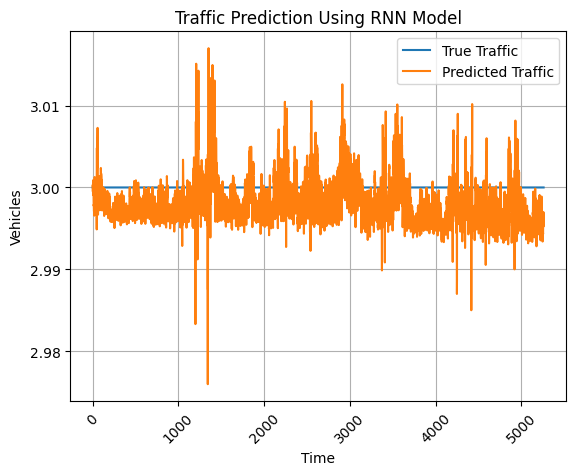

In [30]:
# Inverse
Y_test_rescaled = scaler.inverse_transform(np.concatenate((Y_test.reshape(-1, 1), np.zeros((Y_test.shape[0], 2))), axis=1))[:, 0]
predictions_rescaled_RNN = scaler.inverse_transform(np.concatenate((test_RNN, np.zeros((test_RNN.shape[0], 2))), axis=1))[:, 0]

plt.plot(Y_test_rescaled, label='True Traffic')
plt.plot(predictions_rescaled_RNN , label='Predicted Traffic')
plt.xlabel('Time')
plt.ylabel('Vehicles')
plt.title('Traffic Prediction Using RNN Model')
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)
plt.show()